# Normal-normal model
The goal of this notebook is to provide a step-by-step guide for conducting a Bayesian A/B test using the normal-normal model. We will assume that we are testing two versions of a website, a control version (A) and a variation (B). Our metric of interest is the resulting mean of a continuous variable across 2 groups.

To illustrate the process, we will use a sample dataset that contains `count_* = number of observations in group *` and `avg_* = mean value for group *` and `std_* = standard deviation in group *` for groups A and B.

Here is an example of what the data might look like:

In [1]:
from nn_helpers import *
import pandas as pd
import numpy as np

In [2]:
# Set the random seed to generate a distribution for the control group 0A
np.random.seed(123)
dist_0A = np.random.lognormal(mean=1, sigma=0.5, size=1000)

# Set the random seed to generate a different distribution for the test group 0B
np.random.seed(234)
dist_0B = np.random.lognormal(mean=1.01, sigma=0.6, size=1000)

# Set the random seed to generate a different distribution for the control group 1A
np.random.seed(345)
dist_1A = np.random.lognormal(mean=2, sigma=1, size=1000)

# Set the random seed to generate a different distribution for the test group 1B
np.random.seed(456)
dist_1B = np.random.lognormal(mean=1.98, sigma=0.8, size=1000)

In [3]:
# Define a dictionary with the data for the AB test
data = {
    "metric": ["RPU (Channel A)", "RPU (Channel B)"],
    "count_A": [80000, 1000],
    "avg_A": [np.mean(dist_0A), np.mean(dist_1A)],
    "std_A": [np.std(dist_0A), np.std(dist_1A)],
    "count_B": [80000, 1000],
    "avg_B": [np.mean(dist_0B), np.mean(dist_1B)],
    "std_B": [np.std(dist_0B), np.std(dist_1B)],
}

df = pd.DataFrame(data)
df.head()

,metric,count_A,avg_A,std_A,count_B,avg_B,std_B
0,RPU (Channel A),80000,3.018580,1.599183,80000,3.308413,2.277467
1,RPU (Channel B),1000,11.548615,14.059698,1000,9.963319,9.351295


We will assume that the average for version A is the baseline revenue per user (RPU), and we want to determine whether version B has a higher or lower RPU.

## Setting a Normal prior
For now, we'll proceed a non-informative prior by setting `n_0 = 0`, `mu_0 = 0` and `sigma_0 = 1`.

In [4]:
n_0 = 0
mu_0 = 0
sigma_0 = 1

## Update normal prior

In [5]:
# Set the number of samples to draw from the count. This should be at least 30 for CLT
num_of_samples = 100

# Calculate the updated parameters for the normal prior for version A
params_A = df.apply(
    lambda x: update_normal_prior(
        x["count_A"] / num_of_samples, x["avg_A"], x["std_A"], n_0, mu_0, sigma_0
    ),
    axis=1,
)

# Calculate the updated parameters for the normal prior for version B
params_B = df.apply(
    lambda x: update_normal_prior(
        x["count_B"] / num_of_samples, x["avg_B"], x["std_B"], n_0, mu_0, sigma_0
    ),
    axis=1,
)

In [6]:
# Add the updated parameters for the normal prior to the DataFrame
df = df.assign(
    mu_A=params_A.apply(lambda x: x[0]).values,
    sigma_A=params_A.apply(lambda x: x[1]).values,
    mu_B=params_B.apply(lambda x: x[0]).values,
    sigma_B=params_B.apply(lambda x: x[1]).values,
)
df.head()

,metric,count_A,avg_A,std_A,count_B,avg_B,std_B,mu_A,sigma_A,mu_B,sigma_B
0,RPU (Channel A),80000,3.018580,1.599183,80000,3.308413,2.277467,3.018580,0.056540,3.308413,0.080521
1,RPU (Channel B),1000,11.548615,14.059698,1000,9.963319,9.351295,11.548615,4.446067,9.963319,2.957139


## Bayesian inference

In [7]:
# Calculate the difference between the normal distributions for versions A and B
dnorm = df.apply(
    lambda x: dnorm_B_minus_A(x["mu_A"], x["sigma_A"], x["mu_B"], x["sigma_B"]), axis=1
)

# Calculate the probability that version B is higher than version A
prob_B_higher = dnorm.apply(lambda x: x.sf(0))

In [8]:
# Add the difference and probability to the DataFrame
df = df.assign(dnorm=dnorm, prob_B_higher=prob_B_higher.values)

In [9]:
df.head()

,metric,count_A,avg_A,std_A,count_B,avg_B,std_B,mu_A,sigma_A,mu_B,sigma_B,dnorm,prob_B_higher
0,RPU (Channel A),80000,3.018580,1.599183,80000,3.308413,2.277467,3.018580,0.056540,3.308413,0.080521,<scipy.stats._distn_infrastructure.rv_continuo...,0.998389
1,RPU (Channel B),1000,11.548615,14.059698,1000,9.963319,9.351295,11.548615,4.446067,9.963319,2.957139,<scipy.stats._distn_infrastructure.rv_continuo...,0.383275


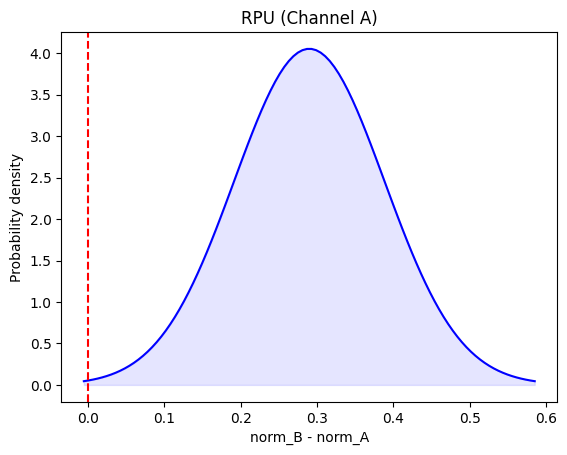

Variant A performed avg_A = 3.0186, std_A = 1.5992 vs avg_B = 3.3084, std_B = 2.2775.
avg_B is +0.2898 higher than avg_A.
You can be 100% confident that this is a result of the changes you made and not a result of random chance.


In [10]:
explain_prob_B_higher(df, 0)

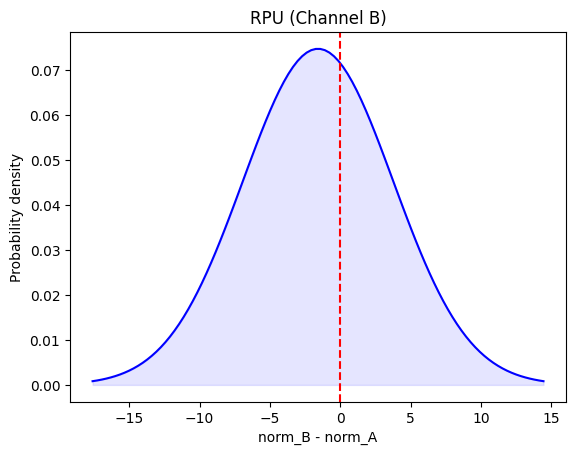

Variant A performed avg_A = 11.5486, std_A = 14.0597 vs avg_B = 9.9633, std_B = 9.3513.
avg_B is -1.5853 lower than avg_A.
You can be 62% confident that this is a result of the changes you made and not a result of random chance.


In [11]:
explain_prob_B_higher(df, 1)